In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path

In [230]:
%run setup_notebooks.py

In [4]:
from src import setup

In [116]:
import logging
logging.getLogger().setLevel(logging.INFO)

# Labels

In [13]:
path, _ = setup.get_data_paths()
path_labels = path.joinpath('CFD/labels')

2022-03-20 14:45:48,101 [setup] [INFO] get_data_path(): using user-defined data path


In [17]:
[
    e.name for e in path_labels.iterdir()
]

['Cases_highrisk_noMI.xlsx',
 'FC_AI_cases_discrepant.xlsx',
 'list of FC.xlsx',
 'Matching.xlsx',
 'WSSdescriptors_AvgValues.xlsx']

In [18]:
df_labels = pd.read_excel(path_labels.joinpath('WSSdescriptors_AvgValues.xlsx'), engine='openpyxl')
df_labels

,Code,TAWSS,OSI,RRT,transWSS,CFI,TAWSSax,TAWSSsc,WSSratio,TSVI,FC
0,CHUV01_LAD,3.64717,0.014050,0.846456,0.073336,0.057265,3.58750,0.158997,0.176172,228.3910,0
1,CHUV01_LCX,2.55975,0.003294,0.611145,0.055230,0.040732,2.48901,0.337315,0.290763,86.0399,1
2,CHUV02_LAD,2.63011,0.005814,0.582346,0.056851,0.040757,2.59072,0.225770,0.202236,60.5216,1
3,CHUV02_LCX,2.98097,0.000154,0.373309,0.039946,0.014991,2.95874,0.257049,0.077637,22.2836,0
4,CHUV02_RCA,2.43675,0.006072,0.583699,0.098474,0.056273,2.29555,0.589120,0.467824,60.5002,0
...,...,...,...,...,...,...,...,...,...,...,...
183,OLV048_LCX,2.53027,0.000036,0.407267,0.017071,0.007672,2.52312,0.127840,0.048128,10.4213,0
184,OLV049_LAD,2.86934,0.010788,0.673836,0.028470,0.035946,2.84023,0.160913,0.326003,102.0050,1
185,OLV049_RCA,2.09383,0.001343,0.756832,0.034190,0.030094,2.02367,0.213538,0.165229,39.1061,0
186,OLV050_LCX,2.82282,0.000498,0.409097,0.058604,0.025448,2.76545,0.386589,0.137708,33.7438,1


In [19]:
df_labels.isna().any(axis=None)

False

In [20]:
df_labels.Code.is_unique

True

In [21]:
df_labels.FC.value_counts()

0    108
1     80
Name: FC, dtype: int64

## Patients statistics

In [22]:
df_labels['patient'] = df_labels.Code.apply(lambda s: s.split('_')[0])

In [23]:
df_labels.patient.nunique()

80

In [24]:
df_labels.groupby('patient').count()['Code'].rename('n_record_per_patient').value_counts()

2    52
3    28
Name: n_record_per_patient, dtype: int64

# Data

In [32]:
path_data = path.joinpath('CFD/ClinicalCFD')
path_magnitude = path_data.joinpath('MagnitudeClinical/')
path_vector = path_data.joinpath('VectorClinical/')

In [33]:
files_magnitude = list(map(lambda e: e.name, path_magnitude.glob('*.vtp')))
files_vector = list(map(lambda e: e.name, path_vector.glob('*.vtp')))

In [34]:
len(files_magnitude), len(files_vector)

(188, 188)

In [35]:
files_vector[:3], files_magnitude[:3]

(['FRH005_LCX_WSS.vtp', 'FRH012_RCA_WSS.vtp', 'OLV009_LAD_WSS.vtp'],
 ['OLV015_LAD_WSSMag.vtp', 'CHUV08_LCX_WSSMag.vtp', 'OLV047_LCX_WSSMag.vtp'])

In [36]:
# Compare patients between the two sets
extract_name_vessel = lambda name: '_'.join(name.split('_')[:-1])

patients_vector = list(map(extract_name_vessel, files_vector))
patients_magnitude = list(map(extract_name_vessel, files_magnitude))
len(set(patients_magnitude)), len(set(patients_vector))

(188, 188)

In [37]:
len(set(patients_vector).intersection(patients_magnitude))

188

# WSS Values

In [5]:
import torch

## Single data point (i.e., graph)

In [216]:
path = setup.get_local_data_path()
sample_wss = path.joinpath('sample_wss.pt')
data = torch.load(sample_wss)
data

Data(x=[3547, 30], edge_index=[2, 21178], y=0, coord=[3547, 3], g_x=[3])

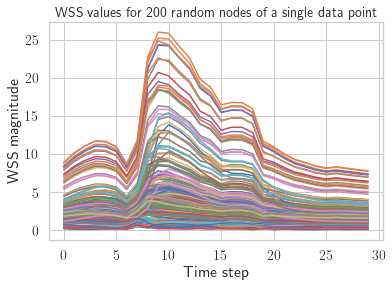

In [217]:
ids = torch.randperm(data.x.shape[0])
take_n = 200
plt.plot(data.x[ids[:take_n]].T)
plt.xlabel('Time step')
plt.ylabel('WSS magnitude')
plt.title(f'WSS values for {take_n} random nodes of a single data point');

## Compare several data points

In [218]:
path = setup.get_dataset_path('WssToCnc_KNN5')
files = list(file for file in path.glob('*.pt') if 'KNN5' not in file.name)
len(files)

2022-03-20 16:01:46,231 [setup] [INFO] get_data_path(): using user-defined data path


188

In [219]:
data = {
    fpath.name: torch.load(fpath) for fpath in files
}
len(data)

188

## Statistics for WSS values

### Maximum WSS values across all nodes



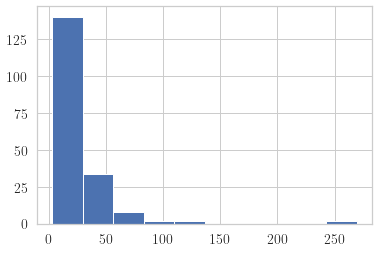

In [220]:
max_wss = [sample.x.max().item() for sample in data.values()]
plt.hist(max_wss);

### Statistics of WSS values across all nodes



In [221]:
df = [
    {
        'fname': fname,
        'y': sample.y,
        'max': sample.x.max().item(),
        'min': sample.x.min().item(),
        'mean': sample.x.mean().item(),
        'median': sample.x.median().item()
    }
    for fname, sample in data.items()
]
df = pd.DataFrame(df)
df

,fname,y,max,min,mean,median
0,CHUV01_LAD.pt,0,14.240928,0.052125,2.539214,2.184747
1,CHUV01_LCX.pt,1,38.117691,0.035272,3.524113,2.641639
2,CHUV02_LAD.pt,1,16.567072,0.038439,2.129455,1.790440
3,CHUV02_LCX.pt,0,9.141841,0.249737,2.199678,1.844735
4,CHUV02_RCA.pt,0,9.979980,0.018594,1.972398,1.658392
...,...,...,...,...,...,...
183,OLV048_LCX.pt,0,9.084010,0.052825,1.361105,1.109133
184,OLV049_LAD.pt,1,16.934998,0.021341,3.109328,2.532758
185,OLV049_RCA.pt,0,12.819361,0.040273,1.739379,1.094731
186,OLV050_LCX.pt,1,14.567917,0.175114,2.578892,2.273204


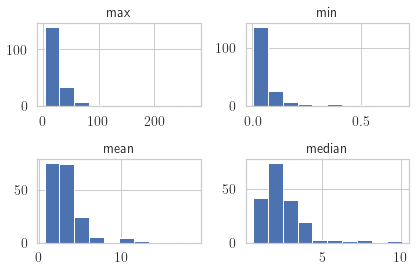

In [222]:
df.drop(columns='y').hist()
plt.tight_layout()

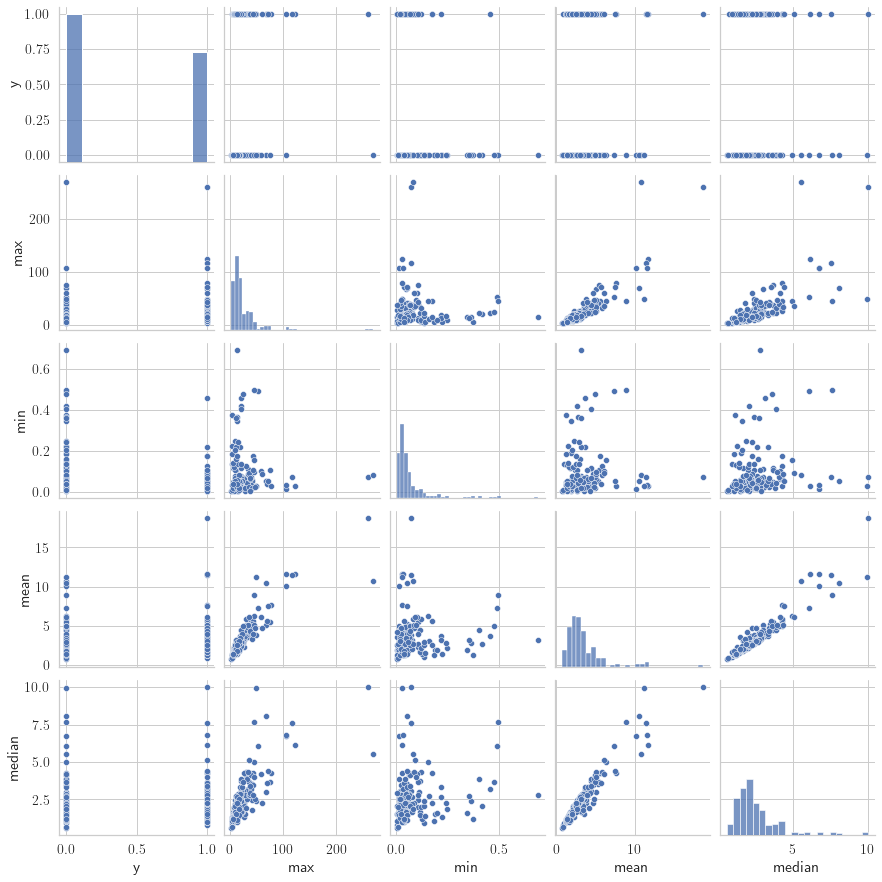

In [223]:
sns.pairplot(df);

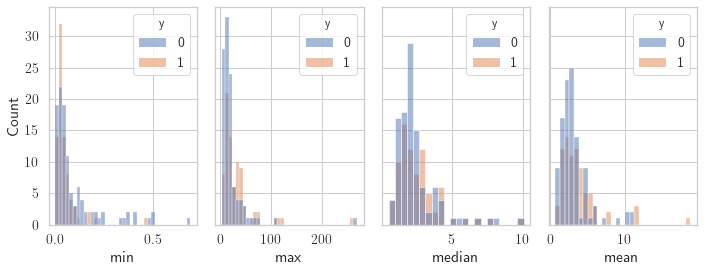

In [224]:
_, ax = plt.subplots(1, 4, figsize=(10, 4), sharey=True)

for col, a in zip(['min', 'max', 'median', 'mean'], ax):
    sns.histplot(data=df, x=col, hue='y', ax=a)
    
plt.tight_layout()

### Get outliers

In [225]:
df_outliers = df[(df['max'] > 200)]
outliers = df_outliers.fname.tolist()
df_outliers

,fname,y,max,min,mean,median
5,CHUV03_LAD.pt,1,260.971252,0.073499,18.685675,10.034504
42,OLV036_LAD.pt,0,269.395020,0.084717,10.732800,5.544541


In [226]:
outliers

['CHUV03_LAD.pt', 'OLV036_LAD.pt']

## Visualize subsampled data

In [233]:
n_samples = 30

# Sample data points without outliers
subset = df.fname[~df.fname.isin(outliers)]
subset = subset.sample(n=n_samples).tolist()

# Get corresponding data
subset = {fname: data[fname] for fname in subset}
subset

{'OLV030_RCA.pt': Data(x=[5674, 30], edge_index=[2, 33932], y=0, coord=[5674, 3], g_x=[1, 3]),
 'OLV047_LCX.pt': Data(x=[6416, 30], edge_index=[2, 38392], y=1, coord=[6416, 3], g_x=[1, 3]),
 'OLV045_LAD.pt': Data(x=[5626, 30], edge_index=[2, 33652], y=0, coord=[5626, 3], g_x=[1, 3]),
 'CHUV17_RCA.pt': Data(x=[7687, 30], edge_index=[2, 46012], y=1, coord=[7687, 3], g_x=[1, 3]),
 'CHUV35_LAD.pt': Data(x=[10056, 30], edge_index=[2, 60234], y=0, coord=[10056, 3], g_x=[1, 3]),
 'CHUV05_LCX.pt': Data(x=[7515, 30], edge_index=[2, 44988], y=0, coord=[7515, 3], g_x=[1, 3]),
 'OLV012_RCA.pt': Data(x=[4570, 30], edge_index=[2, 27316], y=0, coord=[4570, 3], g_x=[1, 3]),
 'OLV047_RCA.pt': Data(x=[9024, 30], edge_index=[2, 54040], y=0, coord=[9024, 3], g_x=[1, 3]),
 'CHUV15_LCX.pt': Data(x=[5825, 30], edge_index=[2, 34844], y=1, coord=[5825, 3], g_x=[1, 3]),
 'OLV028_RCA.pt': Data(x=[5302, 30], edge_index=[2, 31706], y=0, coord=[5302, 3], g_x=[1, 3]),
 'OLV022_LCX.pt': Data(x=[6156, 30], edge_index=

In [228]:
def subsample_nodes(data_point, take: int = 200):
    n_nodes = data_point.x.shape[0]
    ids = np.random.choice(n_nodes, take, replace=False)
    return data_point.x[ids, :]

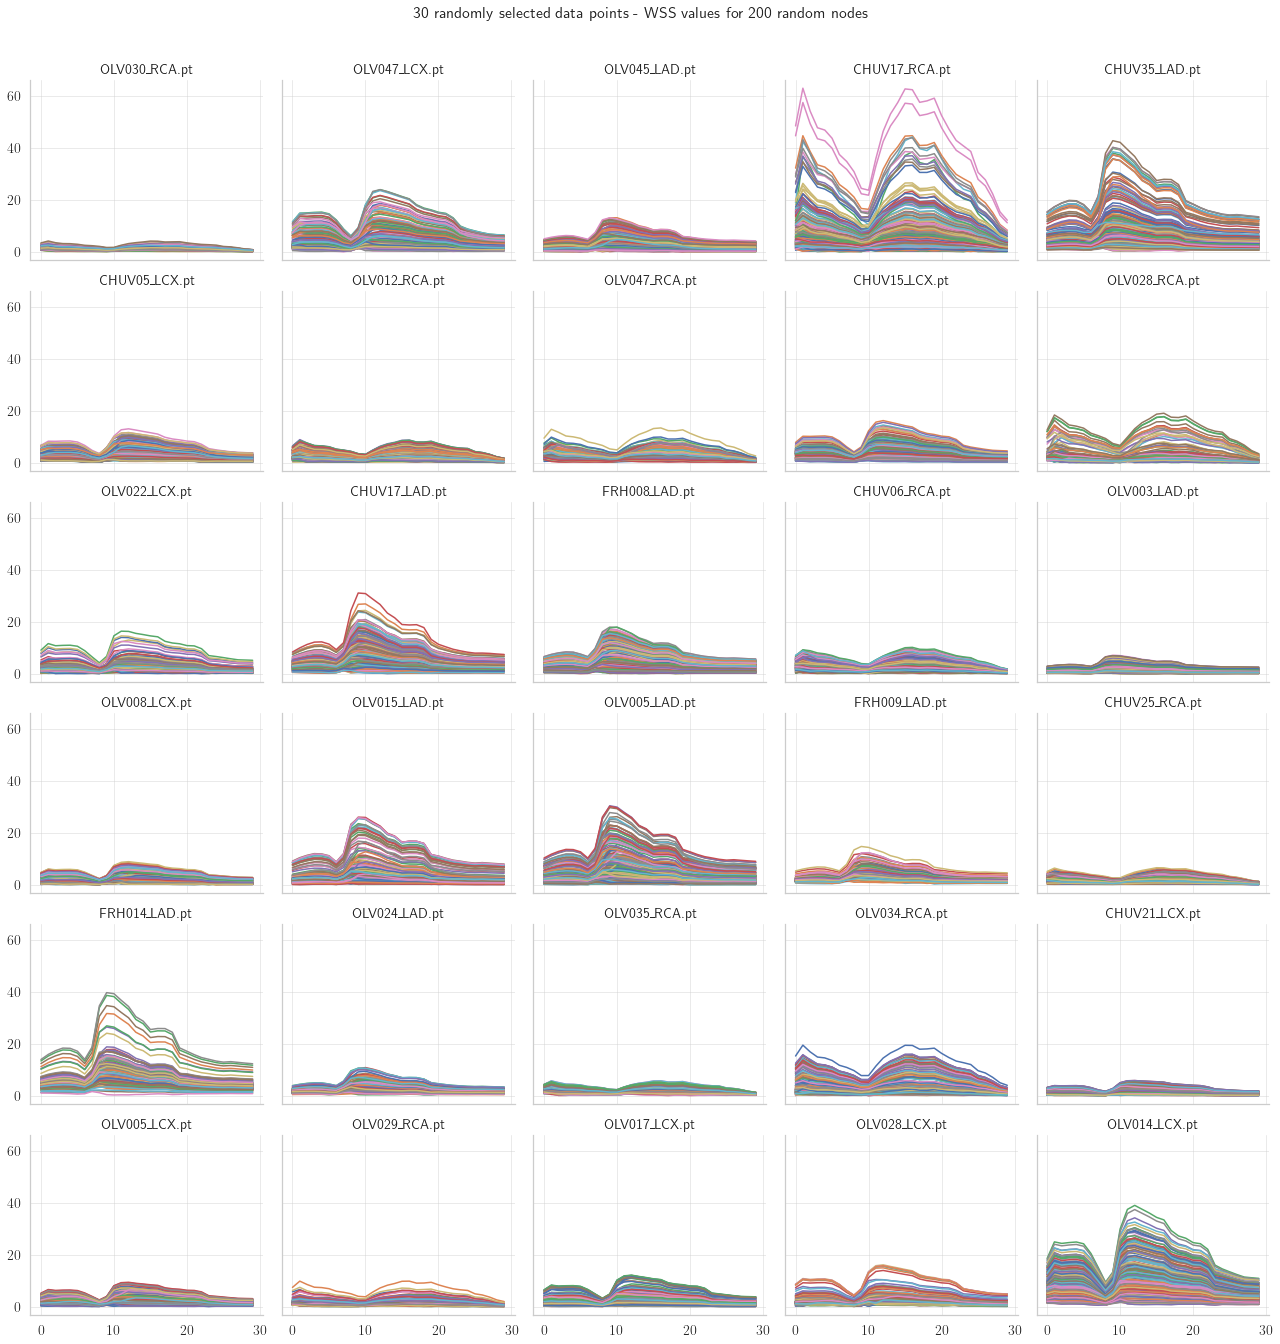

In [234]:
from math import ceil

n_nodes = 200
ncol = 5
nrow = ceil(len(subset) / ncol)
_, ax = plt.subplots(nrow, ncol, figsize=(3.5 * ncol + .5, 3 * nrow + .5), sharex=True, sharey=True)

for (fname, sample), a in zip(subset.items(), ax.ravel()):
    a.set_title(fname)
    data_plot = subsample_nodes(sample, take=n_nodes)
    a.plot(data_plot.T)
    a.grid(alpha=0.4)
    
plt.suptitle(f'{len(subset)} randomly selected data points - WSS values for {n_nodes} random nodes', y=1.01, fontsize=16)
plt.tight_layout()
process_figure('figs/wss_visualization.pdf')

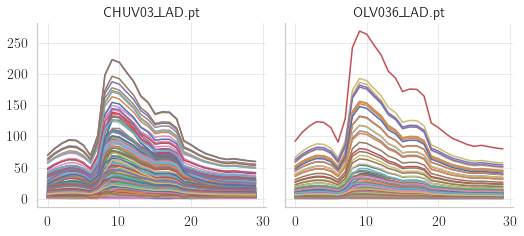

In [235]:
ncol = len(outliers)
nrow = 1
_, ax = plt.subplots(nrow, ncol, figsize=(3.5 * ncol + .5, 3 * nrow + .5), sharex=True, sharey=True)

for outlier, a in zip(outliers, ax.ravel()):
    a.set_title(outlier)
    data_plot = subsample_nodes(data[outlier], take=300)
    a.plot(data_plot.T)
    a.grid(alpha=0.4)
    
    
plt.tight_layout()
process_figure('figs/wss_visualization_outliers.pdf')